In [11]:
import sinter
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
from collections import defaultdict
from typing import Optional, List
import math
import matplotlib
from main.codes.tic_tac_toe.gauge.GaugeFloquetColourCode import GaugeFloquetColourCode
from main.codes.tic_tac_toe.gauge.GaugeHoneycombCode import GaugeHoneycombCode

# Functions used to process the data

In [12]:
def get_sinter_fit(log_ps, sqrt_qs, target_x, stat):
    if len(log_ps) < 2:
        print(stat)
        print('error, only 1 point')
        return None
    
    slope_fit = sinter.fit_line_slope(
        xs=log_ps,
        ys=sqrt_qs,
        max_extra_squared_error=1,
    )
    if slope_fit.best >= 0:
        # Slope is going the wrong way! Definitely over threshold.
        print('error, slope is going the wrong way')
        return None

    fit = sinter.fit_line_y_at_x(
        xs=log_ps,
        ys=sqrt_qs,
        target_x=target_x,
        max_extra_squared_error=1,
    )
    return sinter.Fit(
        low=fit.low**2,
        best=fit.best**2,
        high=fit.high**2,
    )


def extrapolate_footprint_achieving_error_rate(
        group: List[sinter.TaskStats],
        target_p: float,
) -> Optional[sinter.Fit]:
    """Taken from Craig Gidney's code.
    
    Args:
        group: A list of TaskStats objects.
        target_p: The target probability of failure, for teraquop use 1e-12.

    Returns:
        A Fit object representing the footprint that would achieve the target
        probability of failure, or None if the data was insufficient.
    """
    assert len({stat.json_metadata['per'] for stat in group}) == 1
    sqrt_qs = []
    log_ps = []
    for stat in group:
        if stat.shots:
            p_shot = stat.errors / stat.shots
            if 0 < p_shot < 0.5:

                p_unit = p_shot
                sqrt_qs.append(math.sqrt(stat.json_metadata['distance']**2)) # huh why am is squaring and then taking the square root?
                log_ps.append(math.log(p_unit))

    return get_sinter_fit(log_ps, sqrt_qs, math.log(target_p), stat)

def extrapolate_xz_footprint_achieving_error_rate(group: List[sinter.TaskStats],
        target_p: float,
    ) -> Optional[sinter.Fit]:
    assert len({stat.json_metadata['per'] for stat in group}) == 1

    distance_ler_dict = defaultdict(list)

    for stat in group:

        if stat.shots:
            p_shot = stat.errors / stat.shots
            if 0 < p_shot < 0.5:

                p_unit = p_shot
                distance_ler_dict[stat.json_metadata['distance']].append(p_unit)
    sqrt_qs = []
    log_ps = []
    for distance, p_units in distance_ler_dict.items():
        if len(p_units) == 2:
            sqrt_qs.append(math.sqrt(distance**2))
            log_ps.append(math.log(sum(p_units)/2))

    return get_sinter_fit(log_ps, sqrt_qs, math.log(target_p), stat)

# Functions used to generate plots

In [13]:

from typing import Tuple


def float_to_color_shade(value: int, color_map: matplotlib.colors.LinearSegmentedColormap, vmin=200, vmax=3000):
    """
    Convert a float between 1 and 1000 to a shade of blue.

    Parameters
    ----------
    value : float
        The float value to convert.
    vmin : float
        The minimum value of the range. Default is 1.
    vmax : float
        The maximum value of the range. Default is 1000.

    Returns
    -------
    color : tuple
        The RGBA color corresponding to the input value.
    """
    # Normalize the value to the range [0, 1]
    norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
    normalized_value = norm(value)

    # Get the color corresponding to the normalized value
    color : Tuple[int,int,int,int]= color_map(normalized_value)
    return color

def change_opacity(color: Tuple[int,int,int,int], footprint: float, vmin=200, vmax=3000):
    norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
    normalized_value = norm(footprint)
    
    opac_color = (color[0], color[1], color[2], normalized_value)
    return opac_color

# Data processing

### Import and filter data

In [14]:
stats_memory : List[sinter.TaskStats] = sinter.stats_from_csv_files('./out/d_d_d_memory_experiment_0.001.csv')

stats_0001_memory_x = [stat for stat in stats_memory if stat.json_metadata['per'] == 0.001 and stat.json_metadata['logical_observable'] == 'memory_x']
stats_0001_memory_z = [stat for stat in stats_memory if stat.json_metadata['per'] == 0.001 and stat.json_metadata['logical_observable'] == 'memory_z']
stats_0001_memory_xz = stats_0001_memory_x + stats_0001_memory_z

stats_stability : List[sinter.TaskStats] = sinter.stats_from_csv_files('./out/d_d_d_stability_experiment_0.001.csv')
stats_0001_stability_x = [stat for stat in stats_stability if stat.json_metadata['per'] == 0.001 and stat.json_metadata['logical_observable'] == 'stability_x']
stats_0001_stability_z = [stat for stat in stats_stability if stat.json_metadata['per'] == 0.001 and stat.json_metadata['logical_observable'] == 'stability_z']
stats_0001_stability_xz = stats_0001_stability_x + stats_0001_stability_z

### Calculate Teraquop footprints

In [15]:
def calc_teraquop_footprints(stats):
    noise_model_groups = sinter.group_by(stats, key = lambda stat: str(stat.json_metadata['px'])+ ',' + str(stat.json_metadata['py']) + ',' + str(stat.json_metadata['pz']) + ',' + str(stat.json_metadata['pm']))
    noise_model_footprints = defaultdict()

    for noise_model_key, noise_model_group in noise_model_groups.items():

        code_name_groups = sinter.group_by(noise_model_group, key = lambda stat: (stat.json_metadata['code_name'], stat.json_metadata['gf_0'], stat.json_metadata['gf_1'], stat.json_metadata['gf_2']))
        noise_model_footprints[noise_model_key] = defaultdict()
        for code_name_key, code_name_group in code_name_groups.items(): 
            noise_model_footprints[noise_model_key][code_name_key] = extrapolate_footprint_achieving_error_rate(
                    code_name_group,
                    target_p=10**(-12))
    return(noise_model_footprints)



def calc_xz_footprints(stats):
    noise_model_groups = sinter.group_by(stats, key = lambda stat: str(stat.json_metadata['px'])+ ',' + str(stat.json_metadata['py']) + ',' + str(stat.json_metadata['pz']) + ',' + str(stat.json_metadata['pm']))
    noise_model_footprints = defaultdict()

    for noise_model_key, noise_model_group in noise_model_groups.items():

        code_name_groups = sinter.group_by(noise_model_group, key = lambda stat: (stat.json_metadata['code_name'], stat.json_metadata['gf_0'], stat.json_metadata['gf_1'], stat.json_metadata['gf_2']))
        noise_model_footprints[noise_model_key] = defaultdict()
        for code_name_key, code_name_group in code_name_groups.items(): 
            noise_model_footprints[noise_model_key][code_name_key] = extrapolate_xz_footprint_achieving_error_rate(
                    code_name_group,
                    target_p=10**(-12))
    return(noise_model_footprints)

In [16]:
xz_footprints_memory = calc_xz_footprints(stats_0001_memory_xz)
x_footprints_memory = calc_teraquop_footprints(stats_0001_memory_x)
z_footprints_memory = calc_teraquop_footprints(stats_0001_memory_z)

In [17]:
xz_footprints_stability = calc_xz_footprints(stats_0001_stability_xz)
x_footprints_stability = calc_teraquop_footprints(stats_0001_stability_x)
z_footprints_stability = calc_teraquop_footprints(stats_0001_stability_z)

 100000000,         0,         0,  1541.0,pymatching,c11a952a435bd677b88b2fda7effe4de0cbdae4ffd2b03ae610acd7d887655f6,"{""code_name"":""GaugeFloquetColourCode"",""distance"":8,""gf_0"":1,""gf_1"":2,""gf_2"":0,""logical_observable"":""stability_z"",""per"":0.001,""pm"":1.0,""px"":1.0,""py"":1.0,""pz"":16.0}",
error, only 1 point
 100000000,         0,         0,  2588.7,pymatching,8c3b5cbe29bc31b3e9f1516691aeca509a618471973de60ded59085e671044d3,"{""code_name"":""GaugeFloquetColourCode"",""distance"":8,""gf_0"":1,""gf_1"":3,""gf_2"":0,""logical_observable"":""stability_z"",""per"":0.001,""pm"":1.0,""px"":1.0,""py"":1.0,""pz"":16.0}",
error, only 1 point
error, slope is going the wrong way
error, slope is going the wrong way
 100000000,         0,         0,  1492.4,pymatching,281e01b2773a07140a31e0b93dbb3c2451a567fbd0493c216c6185f22559a8ea,"{""code_name"":""GaugeFloquetColourCode"",""distance"":8,""gf_0"":1,""gf_1"":2,""gf_2"":0,""logical_observable"":""stability_z"",""per"":0.001,""pm""

### Find best footprints

In [32]:
def get_best_footprint(footprints: dict):
    lowest_footprint = None
    lowest_footprint_name = None
    lowest_footprint_gauge_honeycomb_code = None
    lowest_footprint_floquet_color_code = None
    for code_name, footprint in footprints.items():
        if footprint is not None and (lowest_footprint is None or footprint.best < lowest_footprint):
            lowest_footprint = footprint.best
            lowest_footprint_name = code_name
        if code_name[0] == 'GaugeHoneycombCode':
            if footprint is not None and (lowest_footprint_gauge_honeycomb_code is None or footprint.best < lowest_footprint_gauge_honeycomb_code):
                lowest_footprint_gauge_honeycomb_code = footprint.best
        if code_name[0] == 'GaugeFloquetColourCode':
            if footprint is not None and (lowest_footprint_floquet_color_code is None or footprint.best < lowest_footprint_floquet_color_code):
                lowest_footprint_floquet_color_code = footprint.best
    return lowest_footprint_name, lowest_footprint, lowest_footprint_gauge_honeycomb_code, lowest_footprint_floquet_color_code

def get_best_footprint_dict(footprints: dict):
    best_footprints = dict()
    best_footprints_honeycomb_code_value = dict()
    best_footprints_floquet_color_code_value = dict()
    for noise_model, footprints in footprints.items():
        best_footprints[noise_model], _, best_footprints_honeycomb_code_value[noise_model], best_footprints_floquet_color_code_value[noise_model] = get_best_footprint(footprints)

    return best_footprints, best_footprints_honeycomb_code_value, best_footprints_floquet_color_code_value

best_footprints = dict(
)
best_footprints['x_memory'], best_footprints['XYZ_x_memory'], best_footprints['CSS_x_memory'] = get_best_footprint_dict(x_footprints_memory)
best_footprints['z_memory'], best_footprints['XYZ_z_memory'], best_footprints['CSS_z_memory'] = get_best_footprint_dict(z_footprints_memory)
best_footprints['xz_memory'], best_footprints['XYZ_xz_memory'], best_footprints['CSS_xz_memory'] = get_best_footprint_dict(xz_footprints_memory)
best_footprints['x_stability'], best_footprints['XYZ_x_stability'], best_footprints['CSS_x_stability'] = get_best_footprint_dict(x_footprints_stability)
best_footprints['z_stability'], best_footprints['XYZ_z_stability'], best_footprints['CSS_z_stability'] = get_best_footprint_dict(z_footprints_stability)
best_footprints['xz_stability'], best_footprints['XYZ_xz_stability'], best_footprints['CSS_xz_stability'] = get_best_footprint_dict(xz_footprints_stability)

# Generate plots

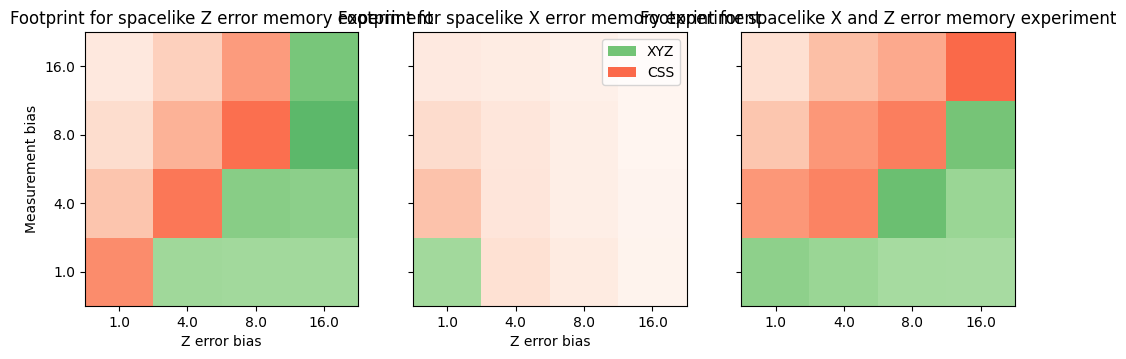

In [33]:
def plot_best_footprints(best_footprints: dict, best_footprints_honeycomb_code_value: dict, best_footprints_floquet_color_code_value: dict, ax: plt.Axes):

    x_y_to_color = dict()
    x_values = list()
    y_values = list()
    for noise_model, best_footprint in best_footprints.items():
        x_val = float(noise_model.split(',')[-2])
        y_val = float(noise_model.split(',')[-1])
    
        if best_footprint[0] == 'GaugeHoneycombCode':
            x_y_to_color[(x_val, y_val)] = float_to_color_shade(best_footprints_honeycomb_code_value[noise_model], plt.cm.Greens)
        elif best_footprint[0] == 'GaugeFloquetColourCode':
            x_y_to_color[(x_val, y_val)] = float_to_color_shade(best_footprints_floquet_color_code_value[noise_model], plt.cm.Reds)    

        if x_val not in x_values:
            x_values.append(x_val)
        if y_val not in y_values:
            y_values.append(y_val)


    x_values.sort()
    y_values.sort()



    color_matrix = [[0 for i in range(len(y_values))] for j in range(len(x_values))]
    for x_val in x_values:
        for y_val in y_values:
            if (x_val, y_val) in x_y_to_color:
                color_matrix[y_values.index(y_val)][x_values.index(x_val)] = x_y_to_color[(x_val, y_val)]

    ax.imshow(color_matrix, origin = 'lower')
    ax.set_xticks(np.arange(len(x_values)), labels=x_values)
    ax.set_yticks(np.arange(len(y_values)), labels=y_values)


fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 6), sharey=True)
ax1.set_ylabel('Measurement bias')
ax1.set_xlabel('Z error bias')
ax2.set_xlabel('Z error bias')
ax1.set_title('Footprint for spacelike Z error memory experiment')
ax2.set_title('Footprint for spacelike X error memory experiment')
ax3.set_title('Footprint for spacelike X and Z error memory experiment')


plot_best_footprints(best_footprints['x_memory'], best_footprints['XYZ_x_memory'], best_footprints['CSS_x_memory'], ax1)
plot_best_footprints(best_footprints['z_memory'], best_footprints['XYZ_z_memory'], best_footprints['CSS_z_memory'], ax2)
plot_best_footprints(best_footprints['xz_memory'], best_footprints['XYZ_xz_memory'], best_footprints['CSS_xz_memory'], ax3)

from  matplotlib.patches import Patch

legend_elements = [
    Patch(facecolor=plt.cm.Greens(0.5), label='XYZ'),##edgecolor='r', label='GaugeHoneycombCode'),
    Patch(facecolor=plt.cm.Reds(0.5), label='CSS')
]

#ax1.legend(handles=legend_elements, loc='upper right')
ax2.legend(handles=legend_elements, loc='upper right')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[(0.0, 0.0, 1.0, 0.09090909090909091), (0.0, 0.0, 1.0, 0.13636363636363635), (0.0, 0.0, 1.0, 0.18181818181818182), (0.0, 0.0, 1.0, 0.22727272727272727), (0.0, 0.0, 1.0, 0.2727272727272727), (0.0, 0.0, 1.0, 0.3181818181818182), (0.0, 0.0, 1.0, 0.36363636363636365), (0.0, 0.0, 1.0, 0.4090909090909091), (0.0, 0.0, 1.0, 0.45454545454545453), (0.0, 0.0, 1.0, 0.5), (0.0, 0.0, 1.0, 0.5454545454545454), (0.0, 0.0, 1.0, 0.5909090909090909), (0.0, 0.0, 1.0, 0.6363636363636364), (0.0, 0.0, 1.0, 0.6818181818181818), (0.0, 0.0, 1.0, 0.7272727272727273), (0.0, 0.0, 1.0, 0.7727272727272727), (0.0, 0.0, 1.0, 0.8181818181818182), (0.0, 0.0, 1.0, 0.8636363636363636), (0.0, 0.0, 1.0, 0.9090909090909091), (0.0, 0.0, 1.0, 0.9545454545454546)], [(0.0, 0.047058823529411764, 0.9764705882352941, 0.09090909090909091), (0.0, 0.047058823529411764, 0.9764705882352941, 0.13636363636363635), (0.0, 0.047058823529411764, 0.9764705882352941, 0.18181818181818182), (0.0, 0.047058823529411764, 0.9764705882352941, 0.22727

Text(0.5, 0, 'Z error bias')

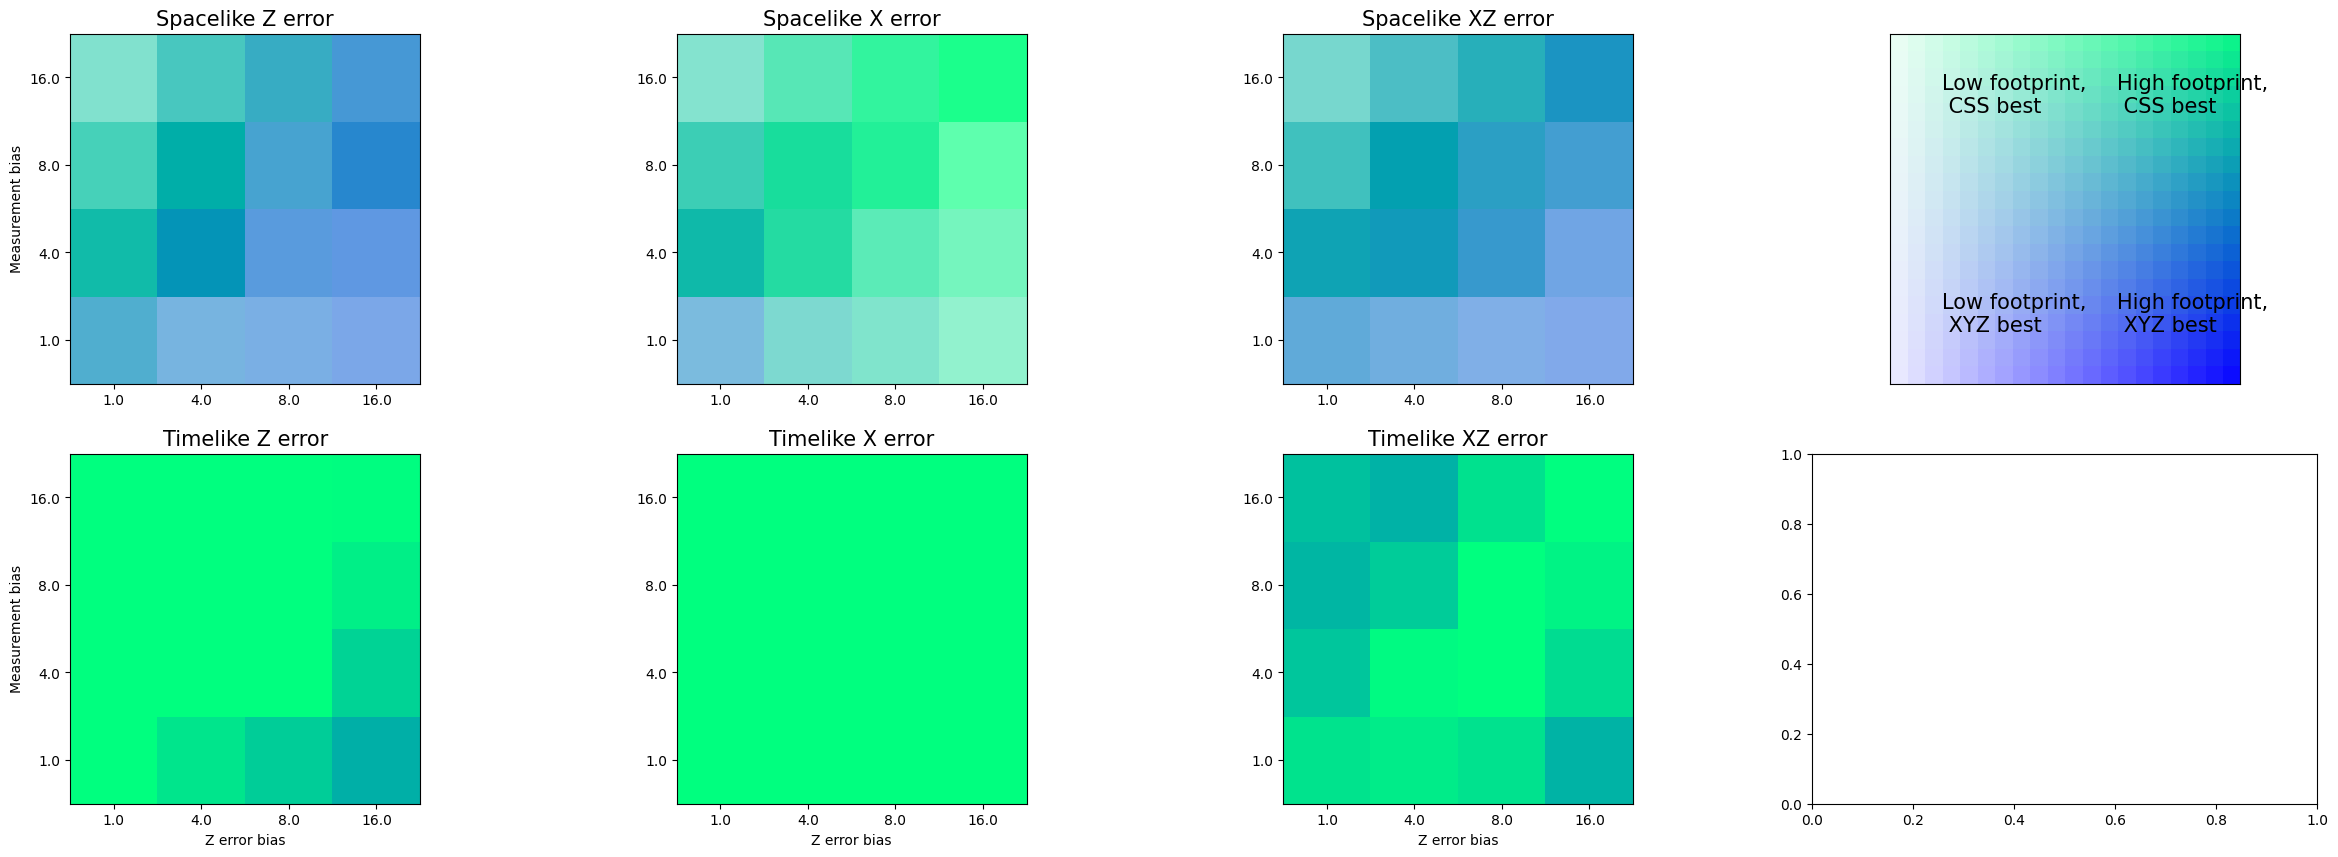

In [48]:

def plot_best_footprints(best_footprints: dict, best_footprints_honeycomb_code_value: dict, best_footprints_floquet_color_code_value: dict, ax: plt.Axes, cmap):

    x_y_to_color = dict()
    x_values = list()
    y_values = list()
    for noise_model, best_footprint in best_footprints.items():
        x_val = float(noise_model.split(',')[-2])
        y_val = float(noise_model.split(',')[-1])
        log_ratio = np.log(best_footprints_honeycomb_code_value[noise_model]/best_footprints_floquet_color_code_value[noise_model])

        if x_val not in x_values:
            x_values.append(x_val)
        if y_val not in y_values:
            y_values.append(y_val)
        color = float_to_color_shade(log_ratio, plt.colormaps[cmap], vmin=-2, vmax=2)
        x_y_to_color[(x_val, y_val)] = change_opacity(color, best_footprints_honeycomb_code_value[noise_model], vmin=400, vmax=2000)

    x_values.sort()
    y_values.sort()

    color_matrix = [[0 for i in range(len(y_values))] for j in range(len(x_values))]
    for x_val in x_values:
        for y_val in y_values:
            if (x_val, y_val) in x_y_to_color:
                color_matrix[y_values.index(y_val)][x_values.index(x_val)] = x_y_to_color[(x_val, y_val)]

    im = ax.imshow(color_matrix, cmap=cmap, origin = 'lower')
    ax.set_xticks(np.arange(len(x_values)), labels=x_values)
    ax.set_yticks(np.arange(len(y_values)), labels=y_values)
    return(im)

ax3 : plt.Axes
fig, axes = plt.subplots(2, 4, figsize=(30, 10), sharey=False)

cmap = 'winter'

for footprint_type, axis in zip(['x_memory', 'z_memory', 'xz_memory', 'x_stability', 'z_stability', 'xz_stability'], list(axes.flatten()[0:3])+list(axes.flatten()[4:])):
    plot_best_footprints(best_footprints[footprint_type], best_footprints['XYZ_'+footprint_type], best_footprints['CSS_'+footprint_type], axis, cmap)

n_points = 20
x_y_values = [(int(x), int(y)) for x in range(0,n_points) for y in range(0, n_points)]

color_matrix = [[0 for i in range(0,n_points)] for j in range(0,n_points)]

for x, y in x_y_values:
    c = float_to_color_shade(x,  plt.colormaps[cmap], vmin=0, vmax=n_points)
    opaque_c = change_opacity(c, y, vmin=-2, vmax=n_points)
    color_matrix[x][y] = opaque_c

for title, axis in zip(['Spacelike Z error', 'Spacelike X error', 'Spacelike XZ error', ' ', 'Timelike Z error', 'Timelike X error', 'Timelike XZ error'], axes.flatten()):
    axis.set_title(title, fontsize=15)
    print(color_matrix)

axes[0][3].imshow(color_matrix, origin='lower')
axes[0][3].text(x=1/8*n_points, y=1/8*n_points, s='Low footprint,\n XYZ best', fontsize=15)
axes[0][3].text(x=5/8*n_points, y=1/8*n_points, s='High footprint,\n XYZ best', fontsize=15)
axes[0][3].text(x=5/8*n_points, y=3/4*n_points, s='High footprint,\n CSS best', fontsize=15)
axes[0][3].text(x=1/8*n_points, y=3/4*n_points, s='Low footprint,\n CSS best', fontsize=15)
axes[0][3].set_xticks([])
axes[0][3].set_yticks([])

axes[0][0].set_ylabel('Measurement bias')
axes[1][0].set_ylabel('Measurement bias')
axes[1][0].set_xlabel('Z error bias')
axes[1][1].set_xlabel('Z error bias')
axes[1][2].set_xlabel('Z error bias')


In [6]:

def format_code_label(code_name):
    code_name_to_label = {
        'GaugeHoneycombCode': 'HCC',
        'GaugeFloquetColourCode': 'FCC'
    }
    label = code_name_to_label.get(code_name[0], code_name)
    formatted_values = ''.join(map(str, code_name[1:]))
    return f'{label}{formatted_values}'


def plot_footprints(footprints,error_model):
    sorted_items = sorted(footprints[error_model].items(), key=lambda item: item[1].best if item[1] is not None else float('inf'))
    code_name_to_color = {'GaugeFloquetColourCode': 'blue', 'GaugeHoneycombCode': 'red'}
    for code_name, footprint in sorted_items:
        
        

        if footprint is not None:
            formatted_label = format_code_label(code_name)

            bars = plt.bar(str(code_name), float(footprint.best), color=code_name_to_color.get(code_name[0], 'black'))
            for bar in bars:
                height = bar.get_height() + 100
                plt.text(bar.get_x() + bar.get_width() / 2.0, height, formatted_label, ha='center', va='bottom', rotation=90)

    # Add labels and title
    plt.xlabel('Codes')
    plt.ylabel('Footprints')
    error_rates = error_model.split(',')
    plt.title(f'error model: px {error_rates[0]} py {error_rates[1]} pz {error_rates[2]} pm {error_rates[3]}')
    plt.xticks([])
    plt.show()


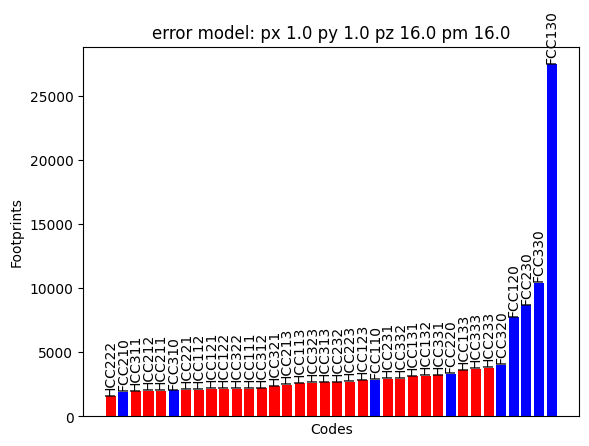

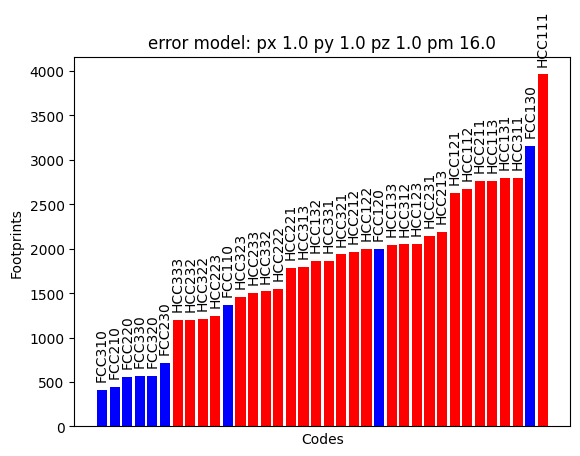

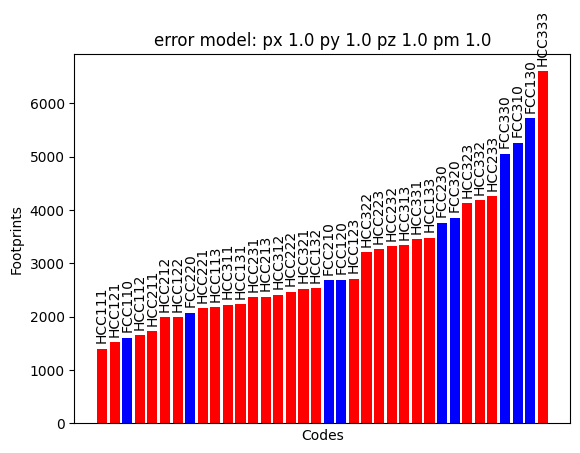

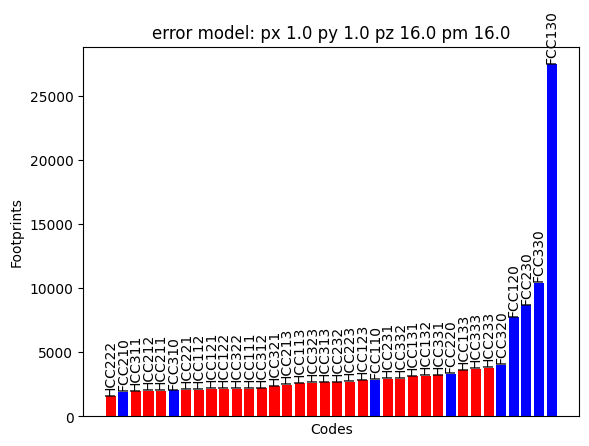

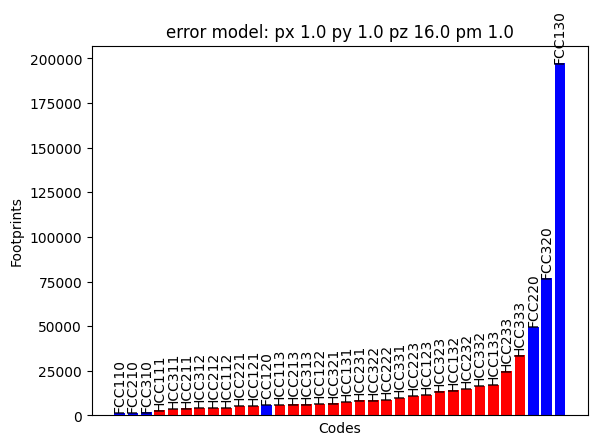

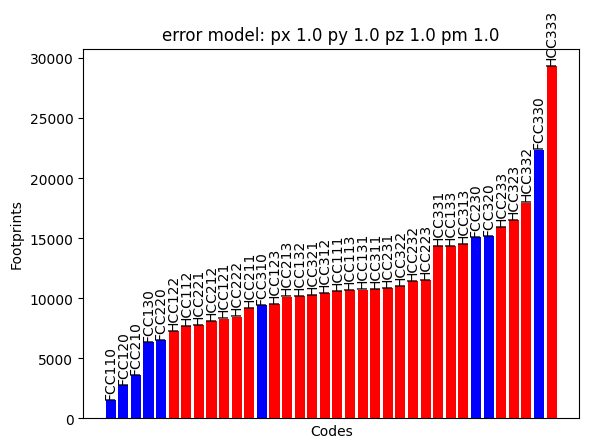

In [20]:
plot_footprints(x_footprints_memory, '1.0,1.0,16.0,16.0')
plot_footprints(x_footprints_memory, '1.0,1.0,1.0,16.0')
plot_footprints(xz_footprints_memory, '1.0,1.0,1.0,1.0')
plot_footprints(x_footprints_memory, '1.0,1.0,16.0,16.0')
plot_footprints(x_footprints_stability, '1.0,1.0,16.0,1.0')
plot_footprints(xz_footprints_stability, '1.0,1.0,1.0,1.0')


In [17]:
""""""
for n_rounds in range(18, 25):

    code: GaugeFloquetColourCode = GaugeFloquetColourCode(4, [3,1])
    circ = generate_circuit(code, n_rounds, 'X', 0.1, 0.1)
    fcc_ds.append(get_hyper_edge_distance(circ))

    code: GaugeHoneycombCode = GaugeHoneycombCode(4, [3,3,3])
    circ =  generate_circuit(code, n_rounds, 'X', 0.1,0.1)
    hcc_ds.append(get_hyper_edge_distance(circ))

print(fcc_ds)
print(hcc_ds)
"""

NameError: name 'GaugeFloquetColourCode' is not defined